---
**Fire Detection Model**
---

---
**Data Preprocessing**
---
Link to first [dataset](https://www.kaggle.com/datasets/tharakan684/urecamain)

Data Preprocessing performed starts by mounting google drive to load the dataset by setting the path to the root directory of the dataset.

## All imports during preprocessing includes;

**cv2**: This module is imported from the OpenCV library and is used for image loading, resizing, and various image processing tasks.

**os**: This module is a part of the Python Standard Library and is used for interacting with the operating system, such as reading file paths, creating directories, or listing files in a directory.

**numpy**: This library is widely used for numerical computations in Python. In this case, it is used to manipulate and process the image data as arrays.

**ImageDataGenerator**: This class is imported from the tensorflow.keras.preprocessing.image module. It is used for data augmentation, generating augmented versions of the images with various transformations.

**Train** subfolder was identified within the dataset, which is stored at /content/drive/MyDrive/fire_detection/Train. Class labels was defined, which are 'Fire' and 'Non-Fire'.

**Image resizing**, target size was set to (128,128). After, looped through the class labels and the images within each class subfolder. For each image, loaded it using cv2.imread() and resized it using cv2.resize() to match the target size.

**Image Normalization**: resized image was normalized by dividing it by 255.0 to bring the pixel values in the range of 0 to 1.

**Image Augmentation**: ImageDataGenerator was used to perform data augmentation. The augmented images were generated using various transformations such as rotation, shifting, shearing, zooming, and flipping.

**Data Storage**: The resized and augmented images in the **image_list** and their corresponding class labels in the **label_list** for further processing.

**ImageDataset**: ImageDataset class was created by providing the **image_list** and **label_list** containing the actual image data and labels, respectively. The train_dataset variable is an instance of the ImageDataset class initialized with the provided image_list and label_list

In [ ]:
# Mount Google drive to load the dataset
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import cv2
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torch.utils.data import Dataset

# Set path to the dataset
dataset_path = '/content/drive/MyDrive/fire_detection/'

# Set path to the train subfolder
train_folder = os.path.join(dataset_path, 'Train')

# Define the class labels
class_labels = ['Fire', 'Non-Fire']

# Define the target size for resizing
target_size = (128, 128)

# Define the number of augmented images to generate per original image
augmentation_factor = 5

# Create an instance of the ImageDataGenerator for data augmentation
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create empty lists to store the images and labels
image_list = []
label_list = []

# Iterate through the class labels
for class_label in class_labels:
    class_folder_path = os.path.join(train_folder, class_label)

    # Iterate through images in each class subfolder
    for image_filename in os.listdir(class_folder_path):
        image_path = os.path.join(class_folder_path, image_filename)

        # Read the image
        image = cv2.imread(image_path)

        # Resize the image
        resized_image = cv2.resize(image, target_size)

        # Normalize the image
        normalized_image = resized_image / 255.0

        # Convert the image to an array of shape (height, width, channels)
        image_array = np.array(normalized_image)

        # Expand the dimensions to (1, height, width, channels)
        image_array = np.expand_dims(image_array, axis=0)

        # Generate augmented images from the original image
        augmented_images = data_generator.flow(image_array, batch_size=1)

        # Iterate through the augmented images and add them to the lists
        for _ in range(augmentation_factor):
            augmented_image = augmented_images.next()[0]
            image_list.append(augmented_image)
            label_list.append(class_label)

# Create a custom dataset class
class ImageDataset(Dataset):
    def __init__(self, image_list, label_list):
        self.images = image_list
        self.labels = label_list

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        return image, label

# Create an instance of the custom dataset class
train_dataset = ImageDataset(image_list, label_list)

## **Validation Data Preprocess**

In [ ]:
# Set path to the validation subfolder
valid_folder = os.path.join(dataset_path, 'Valid')

# Define the class labels
class_labels = ['Fire', 'Non-Fire']

# Define the target size for resizing
target_size = (128, 128)

# Create empty lists to store the images and labels
valid_image_list = []
valid_label_list = []

# Iterate through the class labels
for class_label in class_labels:
    class_folder_path = os.path.join(valid_folder, class_label)

    # Iterate through images in each class subfolder
    for image_filename in os.listdir(class_folder_path):
        image_path = os.path.join(class_folder_path, image_filename)

        # Read the image
        image = cv2.imread(image_path)

        # Resize the image
        resized_image = cv2.resize(image, target_size)

        # Normalize the image
        normalized_image = resized_image / 255.0

        # Convert the image to an array of shape (height, width, channels)
        image_array = np.array(normalized_image)

        # Expand the dimensions to (1, height, width, channels)
        image_array = np.expand_dims(image_array, axis=0)

        valid_image_list.append(image_array)
        valid_label_list.append(class_label)

# Convert the valid lists to arrays
valid_image_array = np.concatenate(valid_image_list, axis=0)
valid_label_array = np.array(valid_label_list)

# Create a custom dataset class
class CustomValidationDataset(Dataset):
    def __init__(self, valid_image_array, valid_label_array):
        self.images = valid_image_array

        self.labels = valid_label_array

    def __len__(self):
        return len(self.valid_image_array)

    def __getitem__(self, index):
        image = self.valid_image_array[index]
        label = self.valid_label_array[index]
        return image, label

# Create an instance of the custom dataset class
valid_dataset = CustomValidationDataset(valid_image_array, valid_label_array)


# **Pretext Task**

To implement the pretext task or a self supervised learning task that can effectively capture the visual features related to fire scenes by leveraging the preprocessed, unlabeled data to guide the learning process.

First Pretext task;
## **Image Inpainting**


1/1 [==============================] - 0s 118ms/step


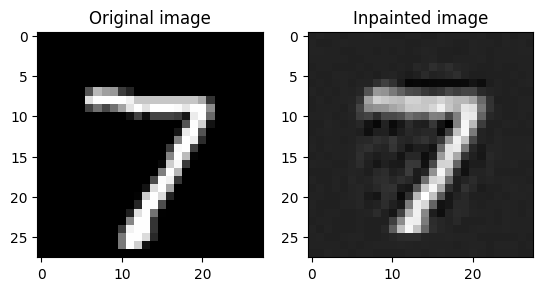

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense
import matplotlib.pyplot as plt

def context_encoder(input_shape):
  """Creates a context encoder model."""
  inputs = Input(input_shape)
  x = Conv2D(32, (3, 3), padding='same')(inputs)
  x = Conv2D(64, (3, 3), padding='same')(x)
  x = Flatten()(x)
  x = Dense(128)(x)
  outputs = Dense(28*28)(x)  # Adjust the output shape to match the input shape
  return keras.Model(inputs, outputs)


def inpaint(image, model):
  """Inpaints a corrupted image using the context encoder model."""
  corrupted_image = image.reshape((1, 28, 28, 1))  # Reshape to match the input shape
  inpainted_image = model.predict(corrupted_image)
  inpainted_image = inpainted_image.reshape((28, 28))  # Reshape to match the output shape
  return inpainted_image

if __name__ == '__main__':
  # Load the training dataset.
  train_dataset = tf.keras.datasets.mnist
  (x_train, y_train), (x_test, y_test) = train_dataset.load_data()

  # Create the context encoder model.
  model = context_encoder((28, 28, 1))

 # Train the context encoder model.
model.compile(optimizer='adam', loss='mean_absolute_error')
model.fit(x_train, x_train.reshape(-1, 784), epochs=1)

# Inpaint a corrupted image.
image = x_test[0]
corrupted_image = image.reshape((1, 28, 28, 1))
inpainted_image = inpaint(corrupted_image, model)

# Display the original and inpainted images.
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Original image')
plt.subplot(122)
plt.imshow(inpainted_image, cmap='gray')
plt.title('Inpainted image')
plt.show()

313/313 [==============================] - 12s 38ms/step - loss: 11.6093
Evaluation Loss: 11.609295845031738
1/1 [==============================] - 0s 76ms/step


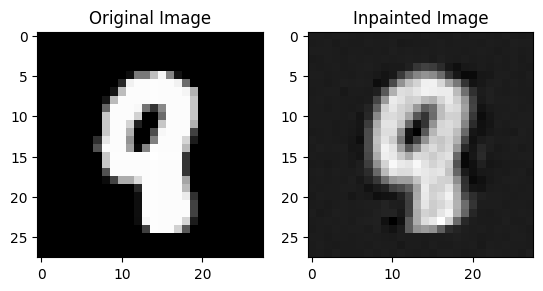

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense
import matplotlib.pyplot as plt

def context_encoder(input_shape):
    """Creates a context encoder model."""
    inputs = Input(input_shape)
    x = Conv2D(32, (3, 3), padding='same')(inputs)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Flatten()(x)
    x = Dense(128)(x)
    outputs = Dense(28*28)(x)  # Adjust the output shape to match the input shape
    return keras.Model(inputs, outputs)


def inpaint(image, model):
    """Inpaints a corrupted image using the context encoder model."""
    corrupted_image = image.reshape((1, 28, 28, 1))  # Reshape to match the input shape
    inpainted_image = model.predict(corrupted_image)
    inpainted_image = inpainted_image.reshape((28, 28))  # Reshape to match the output shape
    return inpainted_image

if __name__ == '__main__':
    # Load the training and validation datasets.
    (x_train, _), (x_valid, _) = tf.keras.datasets.mnist.load_data()

    # Create the context encoder model.
    model = context_encoder((28, 28, 1))

    # Train the context encoder model.
    model.compile(optimizer='adam', loss='mean_absolute_error')
    model.fit(x_train, x_train.reshape(-1, 784), epochs=1)

    # Evaluate the trained model on the validation dataset
    evaluation = model.evaluate(x_valid, x_valid.reshape(-1, 784))
    print('Evaluation Loss:', evaluation)

    # Select a random sample from the validation dataset for visualization
    sample_index = np.random.randint(0, len(x_valid))
    sample_image = x_valid[sample_index]

    # Reshape the sample image to match the input shape of the model
    sample_image_reshaped = sample_image.reshape((1, 28, 28, 1))

    # Inpaint the sample image
    inpainted_sample = inpaint(sample_image_reshaped, model)

    # Display the original and inpainted images
    plt.subplot(121)
    plt.imshow(sample_image, cmap='gray')
    plt.title('Original Image')

    plt.subplot(122)
    plt.imshow(inpainted_sample, cmap='gray')
    plt.title('Inpainted Image')

    plt.show()


## **Pretext Task**

**Colorization**